In [1]:
library(RAnEn)
library(maps)
library(raster)
library(RColorBrewer)

OpenMP is supported.


Package 'RAnEn' version 3.0.8
Copyright (c) 2018 Weiming Hu
Loading required package: sp



## Introduction

This article walks you through the basic usage of the `RAnEn` library in a practice of short-term surface temperature forecasts. Data are prepared using the `generate-data.R` script from [North American Mesoscale Forecast System (NAM)](https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/north-american-mesoscale-forecast-system-nam).

You will learn how to use these functions:

- `generateConfiguration`
- `generateAnalogs`
- `biasCorrection`

## Data Description

First, let's load the prepared NAM model forecasts and analysis.



In [2]:
load('../analysis.RData')
load('../forecasts.RData')
print(ls())

 [1] "analysis"               "analysis.circular.pars" "analysis.indices"      
 [4] "analysis.par.names"     "analysis.times"         "analysis.xs"           
 [7] "analysis.ys"            "flts"                   "forecast.circular.pars"
[10] "forecast.indices"       "forecast.par.names"     "forecast.times"        
[13] "forecast.xs"            "forecast.ys"            "forecasts"             



In total, `r length(forecast.par.names)` parameters are provided in the forecast data set.



In [3]:
print(forecast.par.names)

 [1] "SurfaceTemperature"         "TropoWindU"                
 [3] "TropoWindV"                 "SurfacePressure"           
 [5] "TotalCloudCover"            "TotalPrecipitation"        
 [7] "DownwardShortWaveRadiation" "DownwardLongWaveRadiation" 
 [9] "UpwardShortWaveRadiation"   "UpwardLongWaveRadiation"   



Foreacsts and analysis have the following time range.



In [4]:
print(range(forecast.times))
print(range(analysis.times))

[1] "2017-01-01 UTC" "2018-07-31 UTC"
[1] "2017-01-01 00:00:00 UTC" "2018-07-31 06:00:00 UTC"



Coordinates in lat/lon are provided for grid points. We can plot them on maps. Note that coordinates start from the bottom left grid point and proceed in a row-wise order. There are 11 rows and 11 columns of grid points in the data sets.



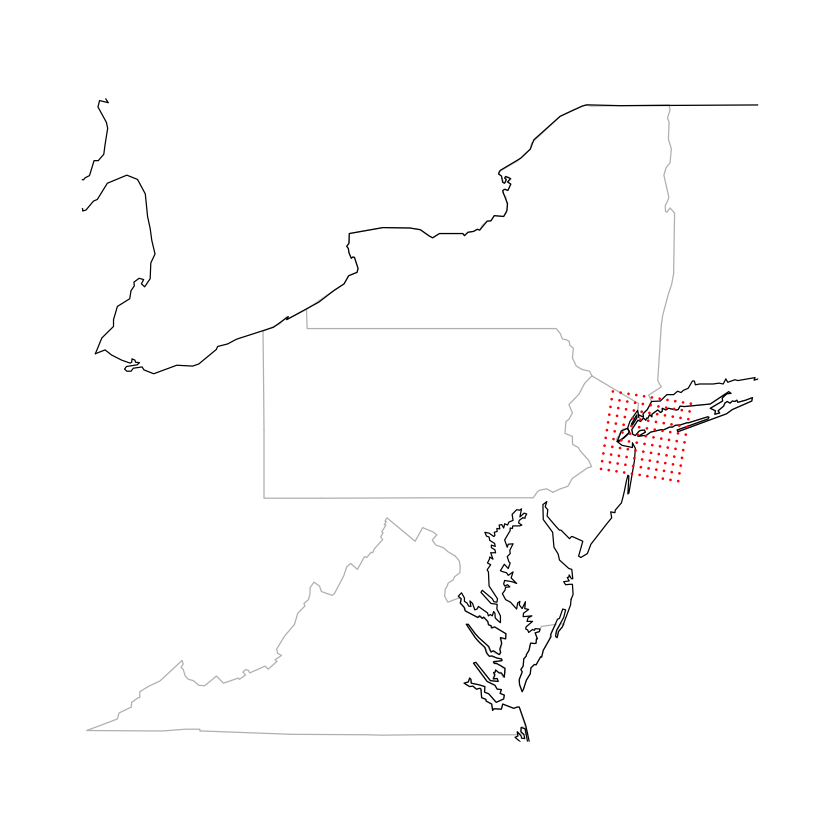

In [5]:
map('state', regions = c('pennsylvania', 'new york', 'virginia'), col = 'grey')
map('usa', add = T)
points(forecast.xs - 360, forecast.ys, pch = 16, cex = .3, col = 'red')


Finally, let's look at the dimensions of forecasts and analysis.



In [6]:
print(dim(forecasts))
print(dim(analysis))

[1]  10 121 576  36
[1]   10  121 2805



Forecasts have 4 dimensions. They are parameters, stations/grid points, days, and Forecast Lead Times (FLTs). Analysis have 3 dimensions. They are parameters, stations/grid points, and time.

## Generate Temperature Forecasts

Now that we have a general idea of the data, we can generate temperature forecasts. The steps to generate AnEn forecasts are as follow:

- Initialize a configuration
- Set up options
- Generate AnEn

First, we set up the configuration. We generate AnEn for one day using about one year of historical data for all the grid points available. If you don't understand any of the options, please see the [document](https://weiming-hu.github.io/AnalogsEnsemble/R/reference/generateConfiguration.html).



In [11]:
# We use independent search configuration.
config <- generateConfiguration('independentSearch')

# Set up options
test.start <- 576
test.end <- 576
search.start <- 1
search.end <- 574
config$test_forecasts <- forecasts[, , test.start:test.end, , drop = F]
config$search_forecasts <- forecasts[, , search.start:search.end, , drop = F]
config$search_times <- forecast.times[search.start:search.end]
config$search_flts <- flts
config$search_observations <- analysis
config$observation_times <- analysis.times
config$weights <- rep(1, dim(forecasts)[1])
config$time_match_mode <- 1
config$num_members <- 40
config$max_flt_nan <- 1
config$max_par_nan <- 0
config$preserve_mapping <- T
config$verbose <- 3


Now we can generate AnEn.



In [12]:
AnEn <- generateAnalogs(config)

[1] "Warning: Converting data/time to numeric for search_times."
[1] "Warning: Converting search_flts to a numeric vector."
[1] "Warning: Converting data/time to numeric for search_observations"
Convert R objects to C++ objects ...
Wraping C++ object mapping ...
Wraping C++ object analogs ...
Done!



Then we need to bias correct AnEn because we are using AnEn on a gridded product.



In [13]:
save(AnEn, file = '~/Desktop/AnEn.RData')

In [ ]:
AnEn <- biasCorrection(AnEn, config, forecast.ID = 1, group.func = mean,
                       na.rm = T, show.progress = F)


`AnEn` is a list of results. Let's check what we have in it.



In [ ]:
print(AnEn)


## Visualization

Finally, we can plot together the analysis, the forecasts, the AnEn, and the bias corrected AnEn. Below the figures are the respective RMSE.



In [ ]:
# Choose a FLT to plot
i.flt <- 31

# Calculate ensemble mean
mean.analogs <- apply(AnEn$analogs[, , , , 1, drop = F], c(1, 2, 3), mean, na.rm = T)
mean.analogs.cor <- apply(AnEn$analogs.cor[, , , , 1, drop = F], c(1, 2, 3), mean, na.rm = T)

# Create an empty raster for the geographical region
xy <- cbind(as.numeric(forecast.xs) - 360, as.numeric(forecast.ys))
colnames(xy) = c('x', 'y')
ext <- extent(xy[, c('x', 'y')])
rast <- raster(ext, nrow = 11, ncol = 11, crs = CRS("+proj=longlat +datum=WGS84"))

# Rasterize the data values
rast.anen <- rasterize(xy[, c('x', 'y')], rast, mean.analogs[, 1, i.flt], fun = mean)
rast.anen.cor <- rasterize(xy[, c('x', 'y')], rast, mean.analogs.cor[, 1, i.flt], fun = mean)
rast.fcts <- rasterize(xy[, c('x', 'y')], rast, forecasts[1, , test.start, i.flt], fun = mean)
rast.anly <- rasterize(xy[, c('x', 'y')], rast, analysis[
  1, , which(analysis.times == forecast.times[test.start] + flts[i.flt])], fun = mean)

# Calculate RMSE
rmse.fcts <- sqrt(mean((values(rast.fcts - rast.anly))^2, na.rm = T))
rmse.anen <- sqrt(mean((values(rast.anen - rast.anly))^2, na.rm = T))
rmse.anen.cor <- sqrt(mean((values(rast.anen.cor - rast.anly))^2, na.rm = T))

# Create a color scale with 100 colors
cols <- colorRampPalette(brewer.pal(11, 'Spectral')[11:1])(100)

# Define value limit
ylim <- range(c(values(rast.fcts), values(rast.anen),
                values(rast.anly), values(rast.anen.cor)),
              na.rm = T)
# Visualization
par(mfrow = c(2, 2), mar = c(4, 1, 3, 3))
plot(rast.anly, main = 'NAM Analysis', col = cols, ylim = ylim, legend = F)
map(col = 'grey', add = T); map('state', add = T)
plot(rast.fcts, main = 'NAM Forecasts', col = cols, ylim = ylim,
     xlab = paste('RMSE =', round(rmse.fcts, 4)))
map(col = 'grey', add = T); map('state', add = T)
plot(rast.anen, main = 'AnEn Averaged', col = cols, ylim = ylim,
     legend = F, xlab = paste('RMSE =', round(rmse.anen, 4)))
map(col = 'grey', add = T); map('state', add = T)
plot(rast.anen.cor, main = 'Bias Corrected AnEn Averaged', col = cols,
     ylim = ylim, xlab = paste('RMSE =', round(rmse.anen.cor, 4)))
map(col = 'grey', add = T); map('state', add = T)